In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chisquare, norm
from sklearn.utils import resample

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
from IPython.display import display, Latex
rc('font', size=20)

In [2]:
N = int(1e5)
mu_true, sig_true = 0, 1
mu_gen, sig_gen = 0.5, 1

epsilon = 1e-10
e = 1e-6
ibu_iterations = 5
n_bootstraps = 1000
rng = np.random.default_rng()
indices = rng.choice(np.arange(N), size=(n_bootstraps, N), replace=True)

truth = rng.normal(mu_true, sig_true, N)
gen = rng.normal(mu_gen, sig_gen, N)

In [3]:
def IBU(prior, data_marginal, alt_response_matrix, n_iterations):
    posterior = [prior]
    for i in range(n_iterations):
        m = alt_response_matrix * posterior[-1]
        m /= (m.sum(axis=1, keepdims=True) + epsilon)
        posterior.append(m.T @ data_marginal)
    return posterior[-1]

In [4]:
smearing = 0.2

data = rng.normal(truth, smearing)
sim = rng.normal(gen, smearing)

data_streams = np.array([truth, data, gen, sim])

In [5]:
bins = [gen.min()]
i = 0
min_elements_per_bin = 5000
while bins[-1] < gen.max() and i < len(bins):
    for binhigh in np.linspace(bins[i] + 0.1, gen.max(), 200):
        in_bin = (gen > bins[i]) & (gen < binhigh)
        in_reco_bin = (sim > bins[i]) & (sim < binhigh)
        if np.sum(in_bin) >= min_elements_per_bin:  # Ensure each bin has at least min_elements_per_bin elements
            purity = np.sum(in_bin & in_reco_bin) / np.sum(in_bin)
            if purity > 0.5**0.5:
                print(f"{binhigh = }, {purity = }")
                i += 1
                bins.append(binhigh)
                break
    else:
        break

bins = np.array(bins)
n_bins = len(bins) - 1
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_widths = np.diff(bins)

print(bins)
print(n_bins)

binhigh = -1.1115990338988202, purity = 0.8679786014520443
binhigh = -0.5485810399060409, purity = 0.7137456683818124
binhigh = 0.015154172398727295, purity = 0.716625133499466
binhigh = 0.5682139720580829, purity = 0.7073647924721665
binhigh = 1.1192959208843014, purity = 0.7134089458437669
binhigh = 1.6680190258358238, purity = 0.7088198928424234
binhigh = 2.205876972935867, purity = 0.7127561136814277
[-3.88922755 -1.11159903 -0.54858104  0.01515417  0.56821397  1.11929592
  1.66801903  2.20587697]
7


## No smearing

In [6]:
smearing = 0.0

data = rng.normal(truth, smearing)
sim = rng.normal(gen, smearing)

data_streams = np.array([truth, data, gen, sim])

In [7]:
bootstrapped_data = np.take(data_streams, indices, axis=1)

In [8]:
bootstrapped_data.shape

(4, 1000, 100000)

In [9]:
np.std(np.mean(bootstrapped_data[1], axis = 1))

0.003156124437418216

In [10]:
digitized_data = np.digitize(bootstrapped_data, bins, right=True)
digitized_data = np.clip(digitized_data - 1, 0, n_bins - 1)
response_matrices = np.empty((n_bootstraps, 2, n_bins, n_bins))

In [11]:
for i in range(n_bootstraps):
    H1, _, _ = np.histogram2d(digitized_data[0, i, :], digitized_data[1, i, :], bins=[range(n_bins+1), range(n_bins+1)])
    H2, _, _ = np.histogram2d(digitized_data[2, i, :], digitized_data[3, i, :], bins=[range(n_bins+1), range(n_bins+1)])    
    response_matrices[i, 0, :, :] = H1
    response_matrices[i, 1, :, :] = H2
normalized_matrices = response_matrices / (response_matrices.sum(axis=3, keepdims=True) + epsilon)

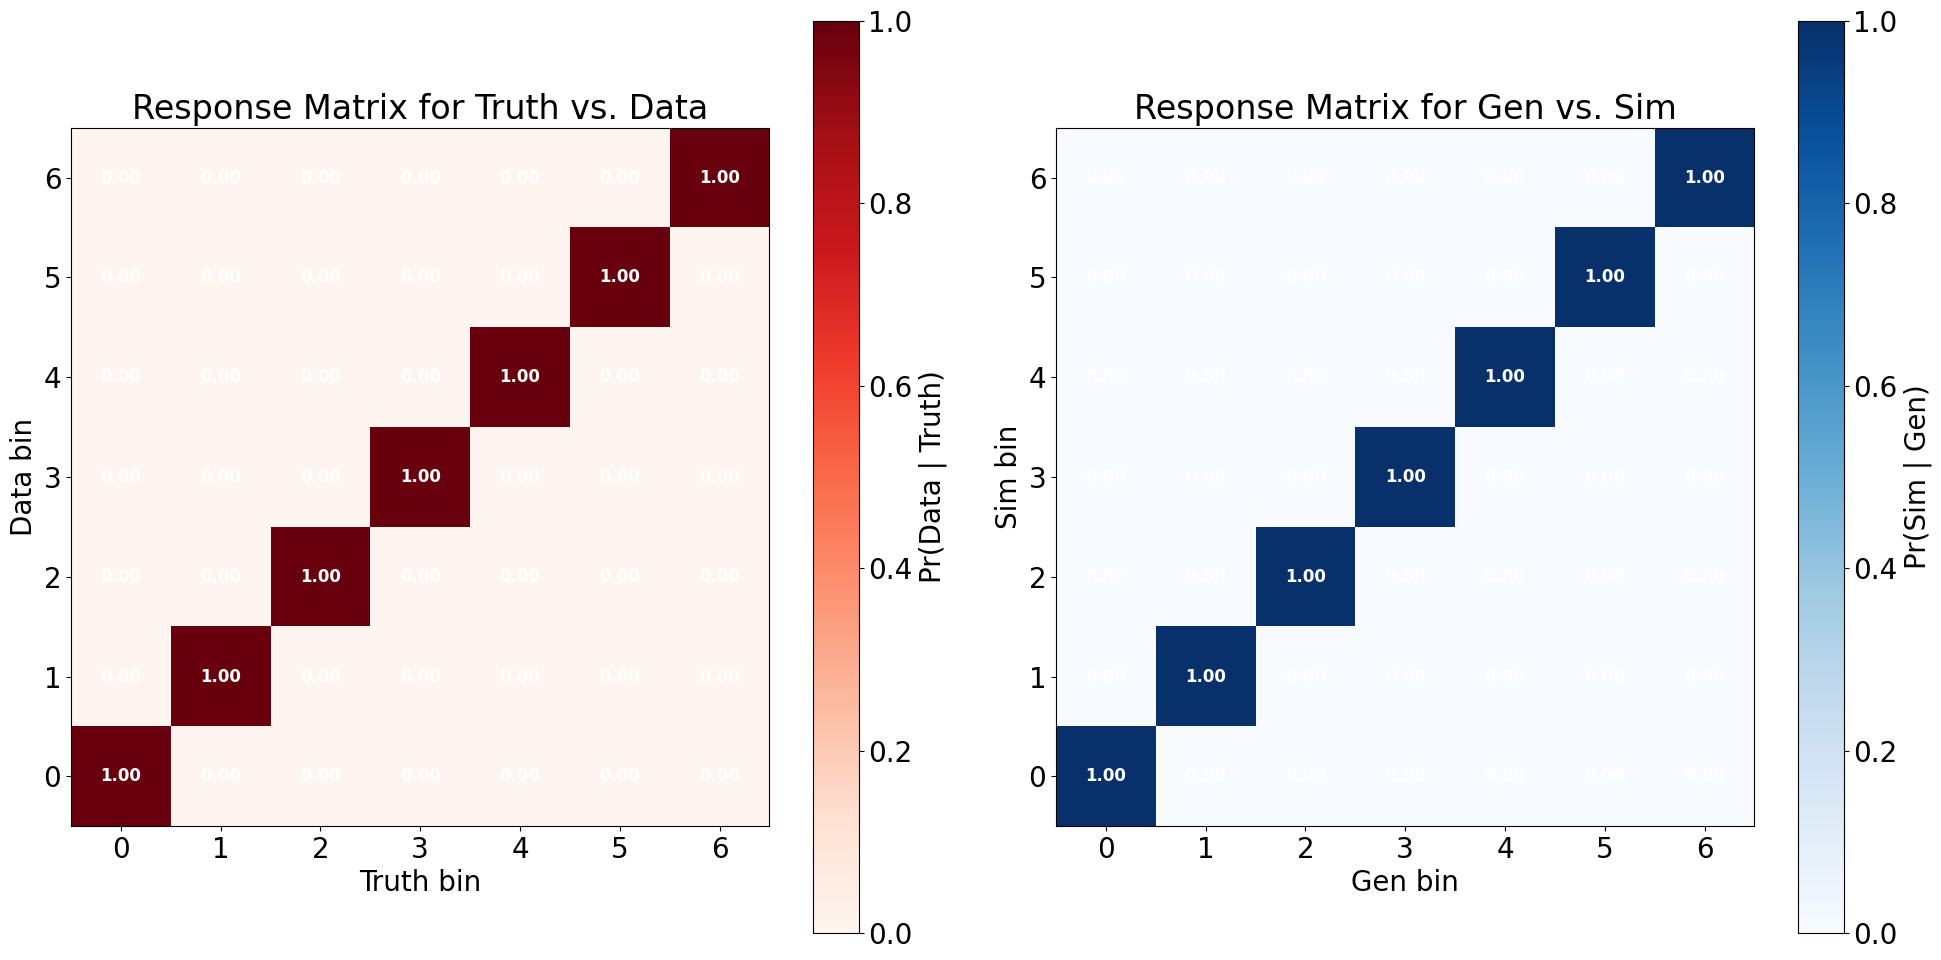

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Two plots in one row

H_normalized = normalized_matrices[29, 0]
H_normalized_alt = normalized_matrices[29, 1]
# First response matrix
im = axs[0].imshow(H_normalized, origin='lower', cmap="Reds", vmin=0, vmax=1)
for i in range(n_bins):
    for j in range(n_bins):
        text = axs[0].text(j, i, f"{H_normalized.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[0].set_title("Response Matrix for Truth vs. Data")
axs[0].set_xlabel("Truth bin")
axs[0].set_ylabel("Data bin")
fig.colorbar(im, ax=axs[0], label='Pr(Data | Truth)')

# Second response matrix
im_alt = axs[1].imshow(H_normalized_alt, origin='lower', cmap="Blues", vmin=0, vmax=1)
for i in range(n_bins):
    for j in range(n_bins):
        text = axs[1].text(j, i, f"{H_normalized_alt.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[1].set_title("Response Matrix for Gen vs. Sim")
axs[1].set_xlabel("Gen bin")
axs[1].set_ylabel("Sim bin")
fig.colorbar(im_alt, ax=axs[1], label='Pr(Sim | Gen)')

plt.tight_layout()
plt.show()

In [13]:
marginals = np.empty((4, n_bootstraps, n_bins), dtype=np.float32)
for i in range(4):
    if i % 2 == 0:
        marginals[i, :, :] = np.sum(response_matrices[:, i // 2, :, :], axis=2)
    else:
        marginals[i, :, :] = np.sum(response_matrices[:, i // 2, :, :], axis=1)

In [14]:
ibu_results = np.empty((n_bootstraps, n_bins), dtype=np.float32)
for i in range(n_bootstraps):
    ibu_results[i] = IBU(marginals[2, i, :], marginals[1, i, :],
                         response_matrices[i, 1, :, :].T, ibu_iterations)

In [15]:
print(ibu_results[0])
print(marginals[1, 0])

[13411. 15881. 21551. 20813. 15182.  8371.  4791.]
[13411. 15881. 21551. 20813. 15182.  8371.  4791.]


In [16]:
ibu_normalized = ibu_results / (ibu_results @ bin_widths)[:, np.newaxis]

In [17]:
cov = np.cov(ibu_normalized.T)
cov_diag = cov * np.identity(n_bins)

In [18]:
print(cov)

[[ 6.73097287e-07 -5.62455280e-07 -8.54480643e-07 -7.74269644e-07
  -7.03822373e-07 -3.06112478e-07 -1.62103653e-07]
 [-5.62455280e-07  2.09890638e-06  1.41866743e-07  2.36491024e-07
   2.59633280e-07  3.24388448e-08  1.65873679e-08]
 [-8.54480643e-07  1.41866743e-07  3.40208863e-06  1.81496815e-07
   3.53556001e-07  5.26316553e-08  9.59026219e-08]
 [-7.74269644e-07  2.36491024e-07  1.81496815e-07  2.97910964e-06
   3.77012376e-07  4.10306718e-08  6.92815247e-08]
 [-7.03822373e-07  2.59633280e-07  3.53556001e-07  3.77012376e-07
   2.40806873e-06  1.38832795e-07 -4.21569087e-09]
 [-3.06112478e-07  3.24388448e-08  5.26316553e-08  4.10306718e-08
   1.38832795e-07  1.26402266e-06  1.77252624e-08]
 [-1.62103653e-07  1.65873679e-08  9.59026219e-08  6.92815247e-08
  -4.21569087e-09  1.77252624e-08  6.34258844e-07]]


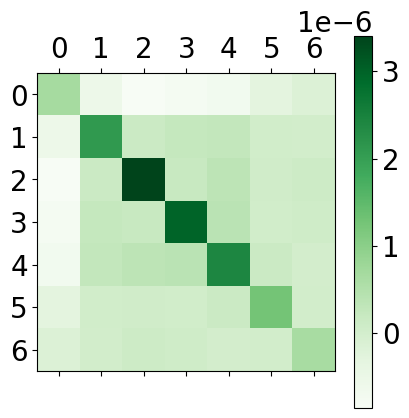

In [19]:
plt.matshow(cov, cmap = "Greens")
plt.colorbar()
plt.show()

In [20]:
fitted_params = np.empty((n_bootstraps, 1))
param_cov = np.empty((n_bootstraps, 1))

for i in range(n_bootstraps):
    fitted_params[i], param_cov[i] = curve_fit(lambda x, mu: norm.pdf(x, mu, 1), bin_centers, 
                                               ibu_normalized[i], 
                                               sigma=cov_diag, absolute_sigma=False)

In [21]:
np.std(fitted_params)

0.010666165836472287

In [22]:
means = []
for i in range(1000):
    means += [np.sum([ibu_normalized[i, k]*bin_centers[k] for k in range(7)])]
np.std(means)

0.004104469724589622

In [40]:
print(e)

1e-06


In [41]:
means = fitted_params[:, 0]

final_mean = np.mean(means)
mean_std_error = np.std(means)

sorted_means = np.sort(means)
lower_bound = np.percentile(sorted_means, (100 - 68) / 2)
upper_bound = np.percentile(sorted_means, 100 - (100 - 68) / 2)

error_down = final_mean - lower_bound
error_up = upper_bound - final_mean

common_exponent = np.floor(np.log10(abs(final_mean)))
scaled_mean = final_mean / 10**common_exponent
scaled_error_down = error_down / 10**common_exponent
scaled_error_up = error_up / 10**common_exponent

formatted_mean = f"{scaled_mean:.6f}"
formatted_error_down = f"{scaled_error_down:.6f}"
formatted_error_up = f"{scaled_error_up:.6f}"

if formatted_error_down == formatted_error_up:
    latex_string = (
        f"The $1\\sigma$ confidence interval for $\\mu$ is: "
        f"$\\mu = ({formatted_mean}\\pm{formatted_error_down}) \\times 10^{{{int(common_exponent)}}}$\n\n"
    )
else:
    latex_string = (
        f"Without correlations the $1\\sigma$ confidence interval for $\\mu$ is: "
        f"$\\mu = ({formatted_mean}_{{-{formatted_error_down}}}^{{+{formatted_error_up}}}) \\times 10^{{{int(common_exponent)}}}$\n\n"
    )

In [42]:
fitted_params_corr = np.empty((n_bootstraps, 1))
param_cov_corr = np.empty((n_bootstraps, 1))

for i in range(n_bootstraps):
    fitted_params_corr[i], param_cov_corr[i] = curve_fit(lambda x, mu: norm.pdf(x, mu, 1), bin_centers, 
                                               ibu_normalized[i], 
                                               sigma=cov)

ValueError: `sigma` must be positive definite.

In [43]:
means_corr = fitted_params_corr[:, 0]

final_mean_corr = np.mean(means_corr)
mean_std_error_corr = np.std(means_corr)

sorted_means_corr = np.sort(means_corr)
lower_bound_corr = np.percentile(sorted_means_corr, (100 - 68) / 2)
upper_bound_corr = np.percentile(sorted_means_corr, 100 - (100 - 68) / 2)

error_down_corr = (final_mean_corr - lower_bound_corr)
error_up_corr = (upper_bound_corr - final_mean_corr)

common_exponent = np.floor(np.log10(abs(final_mean)))
scaled_mean_corr = final_mean_corr / 10**common_exponent
scaled_error_down_corr = error_down_corr / 10**common_exponent
scaled_error_up_corr = error_up_corr / 10**common_exponent

formatted_mean_corr = f"{scaled_mean_corr:.6f}"
formatted_error_down_corr = f"{scaled_error_down_corr:.6f}"
formatted_error_up_corr = f"{scaled_error_up_corr:.6f}"

if formatted_error_down_corr == formatted_error_up_corr:
    latex_string_corr = (
        f"With correlations the $1\\sigma$ confidence interval for $\\mu$ is: "
        f"$\\mu = ({formatted_mean_corr}\\pm{formatted_error_down_corr}) \\times 10^{{{int(common_exponent)}}}$\n\n"
    )
else:
    latex_string_corr = (
        f"With correlations the $1\\sigma$ confidence interval for $\\mu$ is: "
        f"$\\mu = ({formatted_mean_corr}_{{-{formatted_error_down_corr}}}^{{+{formatted_error_up_corr}}}) \\times 10^{{{int(common_exponent)}}}$\n\n"
    )

std_error = np.std(means_corr)



(array([567.,   0.,   0.,   0.,   0.,   0., 388.,   1.,   0.,  43.]),
 array([0.00000000e+000, 6.94736053e-311, 1.38947211e-310, 2.08420816e-310,
        2.77894421e-310, 3.47368026e-310, 4.16841632e-310, 4.86315237e-310,
        5.55788842e-310, 6.25262448e-310, 6.94736053e-310]),
 <BarContainer object of 10 artists>)

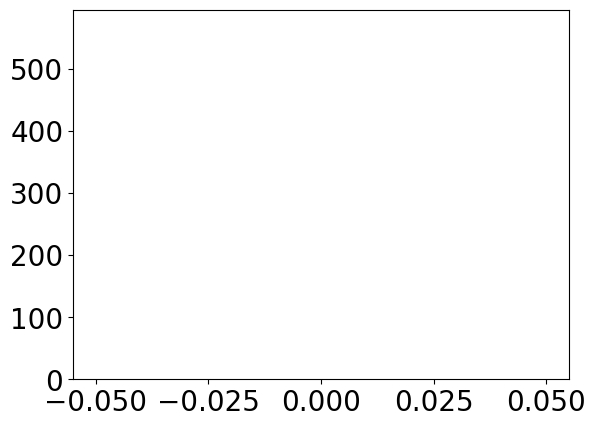

In [44]:
plt.hist(means_corr)

### Final output

In [27]:
print(f"With correlations, 1 sigma width  \t = {(upper_bound_corr - lower_bound_corr)/2:.2e}")
print(f"Without correlations, 1 sigma width \t = {(upper_bound - lower_bound)/2:.2e}")
print(f"Analytic std error of mean\t\t = {std_error:.2e}")

With correlations, 1 sigma width  	 = 1.15e-08
Without correlations, 1 sigma width 	 = 1.07e-08
Analytic std error of mean		 = 1.13e-08


## Smearing

In [28]:
smearing = 0.25

data = rng.normal(truth, smearing)
sim = rng.normal(gen, smearing)

data_streams = np.array([truth, data, gen, sim])

In [29]:
bootstrapped_data = np.take(data_streams, indices, axis=1)

In [30]:
digitized_data = np.digitize(bootstrapped_data, bins)
digitized_data = np.clip(digitized_data - 1, 0, n_bins - 1)
response_matrices = np.empty((n_bootstraps, 2, n_bins, n_bins))

for i in range(n_bootstraps):
    H1, _, _ = np.histogram2d(digitized_data[0, i, :], digitized_data[1, i, :], bins=[range(n_bins+1), range(n_bins+1)])
    H2, _, _ = np.histogram2d(digitized_data[2, i, :], digitized_data[3, i, :], bins=[range(n_bins+1), range(n_bins+1)])    
    response_matrices[i, 0, :, :] = H1
    response_matrices[i, 1, :, :] = H2
normalized_matrices = response_matrices / (response_matrices.sum(axis=3, keepdims=True) + epsilon)

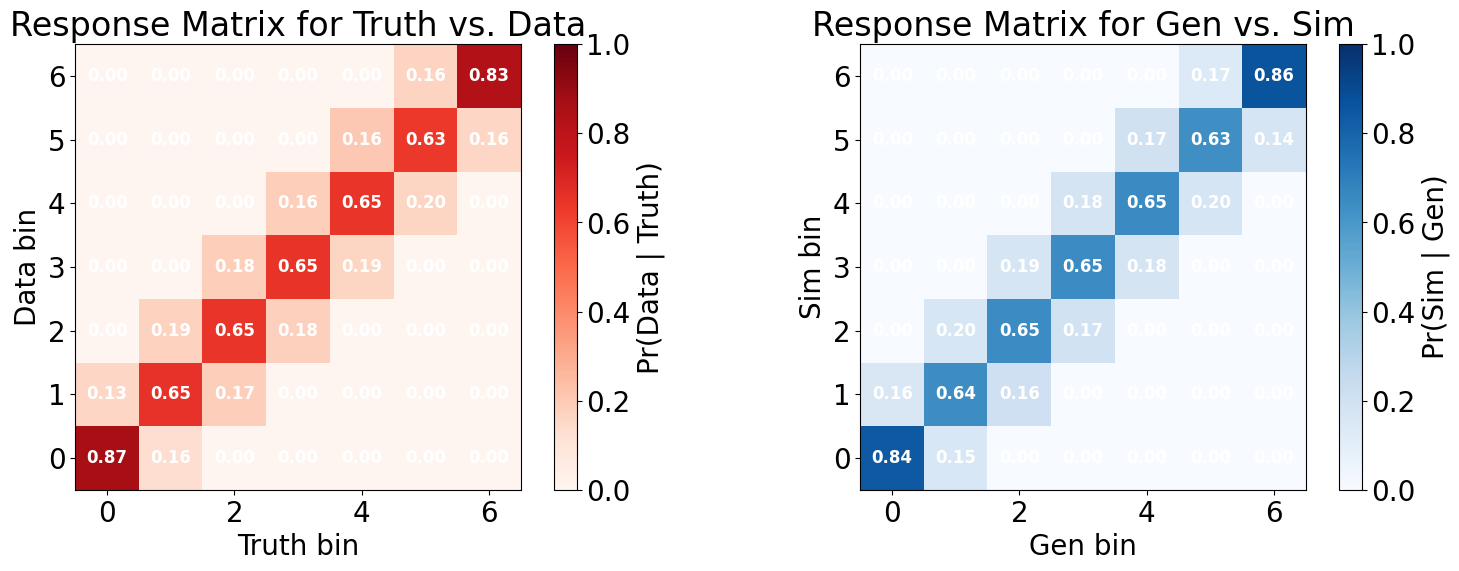

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Two plots in one row

H_normalized = normalized_matrices[946, 0]
H_normalized_alt = normalized_matrices[946, 1]
# First response matrix
im = axs[0].imshow(H_normalized, origin='lower', cmap="Reds", vmin=0, vmax=1)
for i in range(n_bins):
    for j in range(n_bins):
        text = axs[0].text(j, i, f"{H_normalized.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[0].set_title("Response Matrix for Truth vs. Data")
axs[0].set_xlabel("Truth bin")
axs[0].set_ylabel("Data bin")
fig.colorbar(im, ax=axs[0], label='Pr(Data | Truth)')

# Second response matrix
im_alt = axs[1].imshow(H_normalized_alt, origin='lower', cmap="Blues", vmin=0, vmax=1)
for i in range(n_bins):
    for j in range(n_bins):
        text = axs[1].text(j, i, f"{H_normalized_alt.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[1].set_title("Response Matrix for Gen vs. Sim")
axs[1].set_xlabel("Gen bin")
axs[1].set_ylabel("Sim bin")
fig.colorbar(im_alt, ax=axs[1], label='Pr(Sim | Gen)')

plt.tight_layout()
plt.show()

In [32]:
marginals = np.empty((4, n_bootstraps, n_bins), dtype=np.float32)
for i in range(4):
    marginals[i, :, :] = np.sum(response_matrices[:, i // 2, :, :], axis=(2 - i % 2))

In [33]:
ibu_results = np.empty((n_bootstraps, n_bins), dtype=np.float32)
for i in range(n_bootstraps):
    ibu_results[i] = IBU(marginals[2, i, :], marginals[1, i, :],
                         response_matrices[i, 1, :, :].T, ibu_iterations)

In [34]:
ibu_normalized = ibu_results / (ibu_results @ bin_widths)[:, np.newaxis]

In [35]:
cov = np.cov(ibu_normalized.T)
cov_diag = cov*np.identity(n_bins)

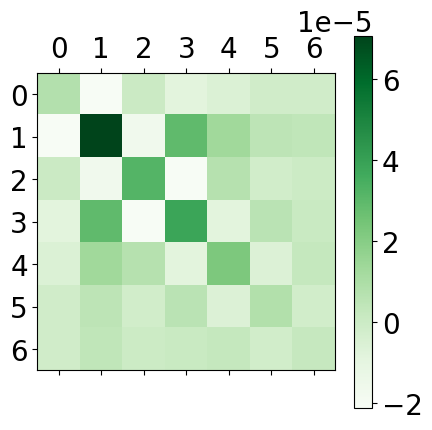

In [36]:
plt.matshow(cov, cmap = "Greens")
plt.colorbar()
plt.show()

In [37]:
fitted_params = np.empty((n_bootstraps, 1))
param_cov = np.empty((n_bootstraps, 1))

for i in range(n_bootstraps):
    fitted_params[i], param_cov[i] = curve_fit(lambda x, mu: norm.pdf(x, mu, 1), bin_centers, 
                                               ibu_normalized[i], 
                                               sigma=cov_diag ** 0.5, absolute_sigma=True)

In [38]:
means = fitted_params[:, 0]

final_mean = np.mean(means)
mean_std_error = np.std(means)

sorted_means = np.sort(means)
lower_bound = np.percentile(sorted_means, (100 - 68) / 2)
upper_bound = np.percentile(sorted_means, 100 - (100 - 68) / 2)

In [39]:
fitted_params_corr = np.empty((n_bootstraps, 1))
param_cov_corr = np.empty((n_bootstraps, 1))

for i in range(n_bootstraps):
    fitted_params_corr[i], param_cov_corr[i] = curve_fit(lambda x, mu: norm.pdf(x, mu, 1), bin_centers, 
                                               ibu_normalized[i], 
                                               sigma=cov, absolute_sigma=True)

ValueError: `sigma` must be positive definite.

In [ ]:
means_corr = fitted_params_corr[:, 0]

final_mean_corr = np.mean(means_corr)
mean_std_error_corr = np.std(means_corr)

sorted_means_corr = np.sort(means_corr)
lower_bound_corr = np.percentile(sorted_means_corr, (100 - 68) / 2)
upper_bound_corr = np.percentile(sorted_means_corr, 100 - (100 - 68) / 2)
std_error = np.std(means_corr)

In [ ]:
print(f"With correlations, 1 sigma width  \t = {(upper_bound_corr - lower_bound_corr)/2:.2e}")
print(f"Without correlations, 1 sigma width \t = {(upper_bound - lower_bound)/2:.2e}")
print(f"Analytic std error of mean\t\t = {std_error:.2e}")